In [1]:
# https://github.com/PhilippeCodes/Advanced-Regression-Techniques/blob/master/house-prices/House-prices%20Gradient%20Boosting.ipynb

In [2]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from math import sqrt
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, HuberRegressor, ElasticNet, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
#from mlxtend.regressor import StackingRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
sns.set()
%matplotlib inline
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
cwd = os.getcwd()
output_dir = os.path.join(cwd, "../../data")
df = pd.read_csv(os.path.join(output_dir, "combined_mydb.csv"))
df_test = pd.read_csv(os.path.join(output_dir, "combined_mydbtest.csv"))
#df_test = pd.read_csv(os.path.join(output_dir, "figlet1599056546.006096_1599063766.431225.csv"))
df = df.drop(df[df.responsetime > 5].index)
df.pop('Time')
df_test = df_test.drop(df_test[df_test.responsetime > 5].index)
df_test.pop('Time')
df.head()

,cpu,diskio,diskioRead,diskioWritten,mem,networkReceived,networkTransmitted,replica,requests,responsetime,totalcpu,totalcpuUtilization,totalmemory,totalmemoryUtilization
0,8.204384,0.011638,949.166080,91963.646862,0.17128,2633.096494,20891.798384,1.0,7.0,1.549383,6.0,44.756118,1.240458e+10,36.551238
1,8.897366,0.017067,133165.511111,140629.333333,0.17128,9030.622222,31243.777778,1.0,17.0,1.546823,6.0,44.756118,1.240458e+10,36.551238
2,8.897366,0.014578,133165.511111,154464.711111,0.17128,8602.355556,34176.288889,1.0,26.0,1.557788,6.0,32.868146,1.240458e+10,37.614600
3,8.740364,0.013956,132346.311111,172942.222222,0.06938,8507.444444,32006.488889,1.0,36.0,1.531037,6.0,32.868146,1.240458e+10,37.614600
4,11.053357,0.010844,0.000000,135259.022222,0.06938,2428.933333,23826.488889,1.0,38.0,1.521409,6.0,25.194444,1.240458e+10,37.446396


In [4]:
#df_test = df_test.append(df[df.totalcpu > 16])

In [5]:
#df_test.reset_index(drop=True, inplace=True)

In [6]:
# remove 2xlarge
df = df.drop(df[df.totalcpu > 16].index)

In [7]:
df.shape

(483, 14)

In [33]:
df_t = pd.DataFrame()
df_ttest = pd.DataFrame()

In [34]:
df_t['total_cpu_util'] = (df['totalcpuUtilization']*(df['totalcpu']*0.67))/100                    
df_t['total_mem_util'] = (df['totalmemoryUtilization']*df['totalmemory'])*1e-9
df_t['responsetime'] = df['responsetime']
df_t['requests'] = df['requests']
#df_t['replica'] = df['replica']
df_ttest['total_cpu_util'] = (df_test['totalcpuUtilization']*(df_test['totalcpu']*0.67))/100
df_ttest['total_mem_util'] = (df_test['totalmemoryUtilization']*df_test['totalmemory'])*1e-9
df_ttest['responsetime'] = df_test['responsetime']
df_ttest['requests'] = df_test['requests']
#df_ttest['replica'] = df_test['replica']
df_t.head()

,total_cpu_util,total_mem_util,responsetime,requests
0,1.799196,453.402624,1.549383,7.0
1,1.799196,453.402624,1.546823,17.0
2,1.321299,466.593178,1.557788,26.0
3,1.321299,466.593178,1.531037,36.0
4,1.012817,464.506675,1.521409,38.0


In [35]:
#n = len(df_t)
#train_df = df_t[0:int(n*0.8)]
#test_df = df_t[int(n*0.8):]
x_train = df_t[[col for col in df_t.columns if col != 'requests']]
y_train = df_t['requests']
#x_train = preprocessing.normalize(x_train, norm='max')
x_test = df_ttest[[col for col in df_ttest.columns if col != 'requests']]
y_test = df_ttest['requests']
#x_test = preprocessing.normalize(x_test, norm='max')

In [36]:
#x_train = train_df[[col for col in train_df.columns if col != 'responsetime']]
#y_train = train_df['responsetime']

#x_test = test_df[[col for col in test_df.columns if col != 'responsetime']]
#y_test = test_df['responsetime']
#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

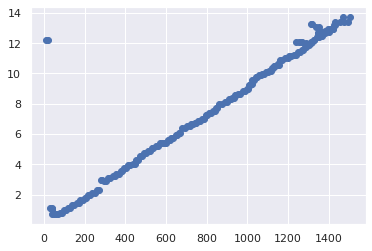

In [37]:
plt.scatter(df_ttest['requests'], df_ttest['total_cpu_util'] )

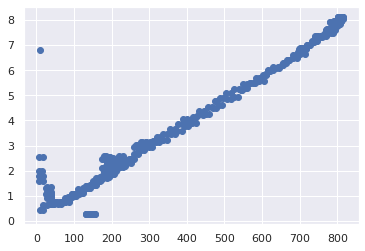

In [38]:
plt.scatter(df_t['requests'], df_t['total_cpu_util'] )

# Linear Regression

linear reg score on our train data: 52.402
linear reg score on our test data: 133.286
R² : 0.9102078173102154
Best Score:  0.750882741334425
Best Params:  {'fit_intercept': False}


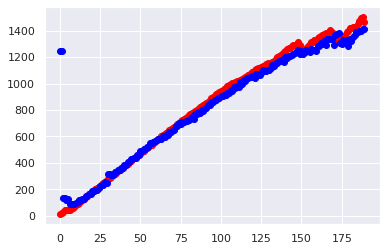

In [39]:
parameters = {'fit_intercept':[True,False]}
linear = GridSearchCV(LinearRegression(),
                      parameters, 
                      cv=7,
                      scoring='r2',
                      n_jobs=-1)
#linear = LinearRegression()
linear.fit(x_train, y_train)

y_tr_pred = linear.predict(x_train)
y_te_pred = linear.predict(x_test)

print('linear reg score on our train data: {:.3f}'.format(sqrt(mse(y_train, y_tr_pred))))
print('linear reg score on our test data: {:.3f}'.format(sqrt(mse(y_test, y_te_pred))))

from sklearn.metrics import r2_score
R = r2_score(y_test, y_te_pred)
print ('R² :',R)
print('Best Score: ', linear.best_score_)
print('Best Params: ', linear.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

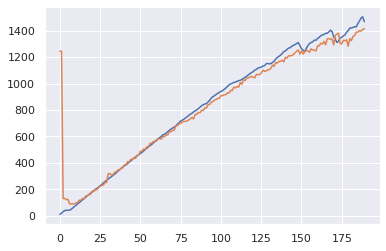

In [40]:
plt.plot(y_test)
plt.plot(y_te_pred)

# Polynomial Regression

linear reg score on our train data: 36.451
linear reg score on our test data: 123.098
R² : 0.9234094570663435
Best Score:  -1.4197232876100452
Best Params:  {'linearregression__fit_intercept': True, 'polynomialfeatures__degree': 2}


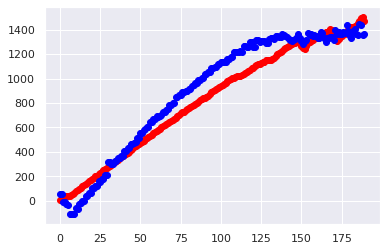

In [41]:
def PolynomialRegression(**kwargs):
    return make_pipeline(PolynomialFeatures(), LinearRegression(**kwargs))
degrees = [2,3,4,5,6 ]
param_grid = {'polynomialfeatures__degree': degrees, 'linearregression__fit_intercept': [True, False]}
polynomial = GridSearchCV(PolynomialRegression(),
                      param_grid, 
                      cv=7,
                      scoring='r2',
                      n_jobs=-1)
polynomial.fit(x_train, y_train)

y_tr_pred = polynomial.predict(x_train)
y_te_pred = polynomial.predict(x_test)

print('linear reg score on our train data: {:.3f}'.format(sqrt(mse(y_train, y_tr_pred))))
print('linear reg score on our test data: {:.3f}'.format(sqrt(mse(y_test, y_te_pred))))

from sklearn.metrics import r2_score
R = r2_score(y_test, y_te_pred)
print ('R² :',R)
print('Best Score: ', polynomial.best_score_)
print('Best Params: ', polynomial.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

# Ridge Regression

RMSLE on our train data: 48.004
RMSLE on our test data: 153.184
R² : 0.8813960946656866
Best Score:  0.7007468135521607
Best Params:  {'alpha': 1e-20}


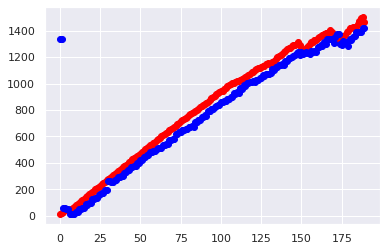

In [42]:
alphas = np.logspace(-20,10,num=20)

ridge_cv = GridSearchCV(Ridge(),
                       {'alpha': alphas},
                         cv=7, 
                         scoring='r2',
                         n_jobs=-1)

ridge_cv.fit(x_train, y_train)

y_tr_pred = ridge_cv.predict(x_train)
y_te_pred = ridge_cv.predict(x_test)

print('RMSLE on our train data: {:.3f}'.format(sqrt(mse(y_train, y_tr_pred))))
print('RMSLE on our test data: {:.3f}'.format(sqrt(mse(y_test, y_te_pred))))

from sklearn.metrics import r2_score
R = r2_score(y_test, y_te_pred)
print ('R² :',R)
print('Best Score: ', ridge_cv.best_score_)
print('Best Params: ', ridge_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

# Lasso Regression

RMSLE on our train data: 60.187
RMSLE on our test data: 249.493
R² : 0.685380117367492
Best Score:  0.6707799032643005
Best Params:  {'alpha': 0.002335721469090121}


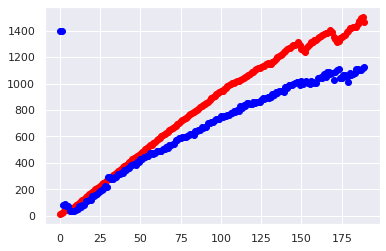

In [19]:
lasso_cv = GridSearchCV(Lasso(),
                       {'alpha': alphas},
                         cv=7, 
                        scoring='r2',
                         n_jobs=-1)

lasso_cv.fit(x_train, y_train)

y_tr_pred = lasso_cv.predict(x_train)
y_te_pred = lasso_cv.predict(x_test)

print('RMSLE on our train data: {:.3f}'.format(sqrt(mse(y_train, y_tr_pred))))
print('RMSLE on our test data: {:.3f}'.format(sqrt(mse(y_test, y_te_pred))))

from sklearn.metrics import r2_score
R = r2_score(y_test, y_te_pred)
print ('R² :',R)
print('Best Score: ', lasso_cv.best_score_)
print('Best Params: ', lasso_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy
 
# Function to create model, required for KerasClassifier
def create_model(optimizer='rmsprop', init='glorot_uniform'):
    # create model
    model = Sequential()
    model.add(Dense(4, input_dim=4, kernel_initializer=init, activation='relu'))
    model.add(Dense(4, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
 
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

model = KerasClassifier(build_fn=create_model, verbose=0)

# grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = [5, 10, 30]
batches = [100, 150]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid,
                   cv=5, 
                         scoring='r2',
                         n_jobs=-1,
                   verbose=10)
grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Grid search and Deeplearning models in python with keras

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [ ]:
# Use scikit-learn to grid search the batch size and epochs
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(4, input_dim=4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load dataset

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 40, 60]
epochs = [10, 50]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=10, scoring='r2')
grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Use scikit-learn to grid search the batch size and epochs
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model(optimizer='adam'):
    # create model
    model = Sequential()
    model.add(Dense(4, input_dim=4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=10)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=10, scoring='r2')
grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Use scikit-learn to grid search the learning rate and momentum
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
# Function to create model, required for KerasClassifier
def create_model(learn_rate=0.01, momentum=0):
    # create model
    model = Sequential()
    model.add(Dense(4, input_dim=4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=10)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(learn_rate=learn_rate, momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=10, scoring='r2')
grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Use scikit-learn to grid search the weight initialization
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model(init_mode='uniform'):
    # create model
    model = Sequential()
    model.add(Dense(4, input_dim=4, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(1, kernel_initializer=init_mode, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=10)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(init_mode=init_mode)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=10, scoring='r2')
grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Use scikit-learn to grid search the activation function
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model(activation='relu'):
    # create model
    model = Sequential()
    model.add(Dense(4, input_dim=4, kernel_initializer='uniform', activation=activation))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=10)
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=10, scoring='r2')
grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Use scikit-learn to grid search the dropout rate
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
# Function to create model, required for KerasClassifier
def create_model(dropout_rate=0.0, weight_constraint=0):
    # create model
    model = Sequential()
    model.add(Dense(4, input_dim=4, kernel_initializer='uniform', activation='linear', kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load dataset

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
weight_constraint = [1, 2, 3, 4, 5]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
param_grid = dict(dropout_rate=dropout_rate, weight_constraint=weight_constraint)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=10, scoring='r2')
grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Use scikit-learn to grid search the number of neurons
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
# Function to create model, required for KerasClassifier
def create_model(neurons=1):
    # create model
    model = Sequential()
    model.add(Dense(neurons, input_dim=4, kernel_initializer='uniform', activation='linear', kernel_constraint=maxnorm(4)))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=10)
# define the grid search parameters
neurons = [5, 6, 10]
param_grid = dict(neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=10, scoring='r2')
grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Huber Regressor

RMSLE on our train data: 53.165
RMSLE on our test data: 133.690
R² : 0.9096625422455556
Best Score:  0.7744742200228413
Best Params:  {'alpha': 1.4384498882876658e-17, 'epsilon': 1.0}


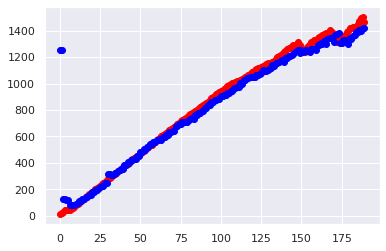

In [43]:
epsilon = np.arange(1, 1.5, 0.05)


huber_cv = GridSearchCV(HuberRegressor(),
                       {'epsilon': epsilon,
                        'alpha': alphas},
                         cv=7, 
                         scoring='r2',
                         n_jobs=-1)

huber_cv.fit(x_train, y_train)

y_tr_pred = huber_cv.predict(x_train)
y_te_pred = huber_cv.predict(x_test)

print('RMSLE on our train data: {:.3f}'.format(sqrt(mse(y_train, y_tr_pred))))
print('RMSLE on our test data: {:.3f}'.format(sqrt(mse(y_test, y_te_pred))))

from sklearn.metrics import r2_score
R = r2_score(y_test, y_te_pred)
print ('R² :',R)
print('Best Score: ', huber_cv.best_score_)
print('Best Params: ', huber_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

# Random Forrest Regressor

0.9921311140395128
0.45176937707517395
RMSLE on our train data: 23.539
RMSLE on our test data: 329.341
R² : 0.45176937707517395
Best Score:  0.7893007513194512
Best Params:  {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 150}


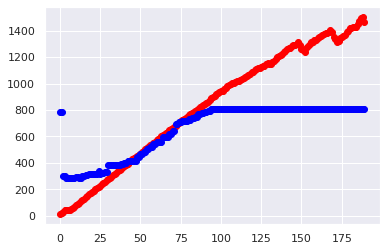

In [44]:
parameters = {  
                 'min_samples_leaf': [2, 4, 6],
                 'max_depth': [10, 15, 20],
                 'n_estimators': [100, 150, 200],
                'max_features': ['auto']
}

rf_cv = GridSearchCV( RandomForestRegressor(),
                      param_grid=parameters, 
                      cv=7, 
                      scoring='r2',
                      n_jobs=-1)

rf_cv.fit(x_train, y_train)

y_tr_pred = rf_cv.predict(x_train)
y_te_pred = rf_cv.predict(x_test)

print(rf_cv.score(x_train,y_train))
print(rf_cv.score(x_test,y_test))

print('RMSLE on our train data: {:.3f}'.format(sqrt(mse(y_train, y_tr_pred))))
print('RMSLE on our test data: {:.3f}'.format(sqrt(mse(y_test, y_te_pred))))

from sklearn.metrics import r2_score
R = r2_score(y_test, y_te_pred)
print ('R² :',R)
print('Best Score: ', rf_cv.best_score_)
print('Best Params: ', rf_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

Test R² : 0.4527539361938324
Train R² : 0.9900362613463859


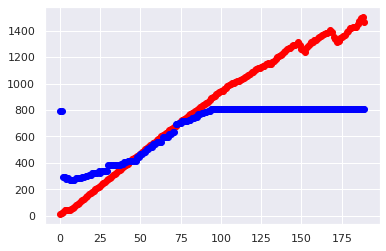

In [45]:
finalrf_cv = RandomForestRegressor(max_depth=20, min_samples_leaf=6, n_estimators=150)
finalrf_cv.fit(x_train, y_train)
y_tr_pred = finalrf_cv.predict(x_train)
y_te_pred = finalrf_cv.predict(x_test)

from sklearn.metrics import r2_score
R = r2_score(y_test, y_te_pred)
print ('Test R² :',R)

R = r2_score(y_train, y_tr_pred)
print ('Train R² :',R)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

# ElasticNet

R² : 0.8812135565199348
Best Score:  0.7012515177988049
Best Params:  {'alpha': 0.08858667904100796, 'l1_ratio': 1}


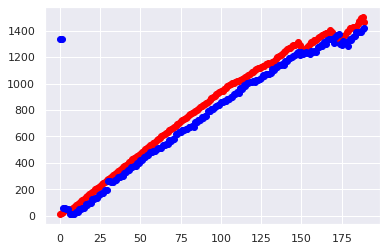

In [46]:
# find optimal alpha with grid search
alpha = np.logspace(-20,10,num=20)
l1_ratio = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
param_grid = dict(alpha=alpha, l1_ratio=l1_ratio)
grid = GridSearchCV(ElasticNet(), 
                    param_grid=param_grid,
                    cv=7,
                    scoring='r2', 
                    n_jobs=-1)

grid_result = grid.fit(x_train, y_train)

y_tr_pred = grid.predict(x_train)
y_te_pred = grid.predict(x_test)
from sklearn.metrics import r2_score
R = r2_score(y_test, y_te_pred)
print ('R² :',R)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

# Gradient Boosting Regressor

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 11.9min finished


RMSLE on our train data: 26.842
RMSLE on our test data: 348.468
R² : 0.38624215732921674
Best Score:  0.9062778326020233
Best Params:  {'learning_rate': 0.02, 'loss': 'lad', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 15, 'min_samples_split': 15, 'n_estimators': 1500}


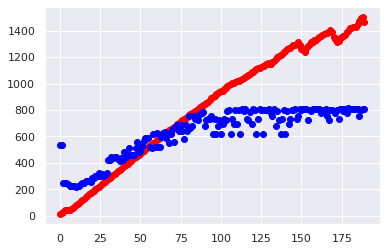

In [47]:
learning_rate = np.arange(0,0.2,0.001)
parameters = {  
                 'learning_rate': [0.02],
                 'min_samples_split': [10, 15, 20],
                 'min_samples_leaf': [10, 15, 20],
                 'max_depth': [3, 4, 5],
                 'n_estimators': [1000, 1500, 2000],
                 'loss': ['ls', 'lad', 'huber', 'quantile'],
                 'max_features': ['sqrt']
             }


GBoost_cv = GridSearchCV(GradientBoostingRegressor(), 
                         param_grid=parameters, 
                         n_jobs=-1, 
                         scoring='r2',
                         cv=5,
                        verbose=1)
#GBoost_cv = GradientBoostingRegressor(learning_rate=0.02)

GBoost_cv.fit(x_train, y_train)

y_tr_pred = GBoost_cv.predict(x_train)
y_te_pred = GBoost_cv.predict(x_test)

print('RMSLE on our train data: {:.3f}'.format(sqrt(mse(y_train, y_tr_pred))))
print('RMSLE on our test data: {:.3f}'.format(sqrt(mse(y_test, y_te_pred))))

from sklearn.metrics import r2_score
R = r2_score(y_test, y_te_pred)
print ('R² :',R)
print('Best Score: ', GBoost_cv.best_score_)
print('Best Params: ', GBoost_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

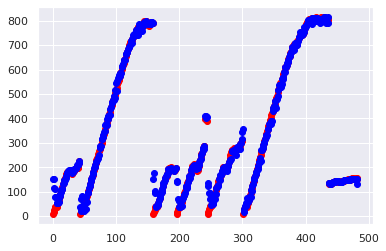

In [48]:
plt.scatter(range(0,len(y_train)),y_train, color='red')
plt.scatter(range(0,len(y_tr_pred)),y_tr_pred, color='blue')

Test R² : 0.3978164729852718
Train R² : 0.9887993501941135


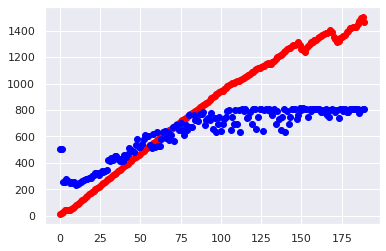

In [49]:
gboostFinal = GradientBoostingRegressor(learning_rate=0.02, 
                                        loss= 'lad', 
                                        max_depth=5, 
                                        max_features= 'sqrt', 
                                        min_samples_leaf= 20, 
                                        min_samples_split= 10, 
                                        n_estimators= 1000)
gboostFinal.fit(x_train, y_train)

y_tr_pred = gboostFinal.predict(x_train)
y_te_pred = gboostFinal.predict(x_test)

from sklearn.metrics import r2_score
R = r2_score(y_test, y_te_pred)
print ('Test R² :',R)

R = r2_score(y_train, y_tr_pred)
print ('Train R² :',R)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')